# Set-up

In [1]:
import numpy as np 
import scipy.stats as sp 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import random 
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels.stats.power
from sklearn.utils import resample
from tqdm.notebook import trange
from typing import List, Tuple, Callable
from collections import Counter

In [2]:
df = sns.load_dataset('diamonds')
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


# 1. Statistical Estimations

## 1.1 Estimates of location

### Central tendencies

In [3]:
[len(df.x),
 np.max(df.x),
 np.min(df.x)]

[53940, 10.74, 0.0]

In [4]:
sp.mode(df.x)

ModeResult(mode=array([4.37]), count=array([448]))

In [5]:
[np.mean(df.x), 
 np.average(df.x, weights = df.carat), 
 np.median(df.x), 
 sp.trim_mean(df.x, 0.1)]

[5.731157211716722, 6.380923712740938, 5.7, 5.660075778642937]

In [6]:
def mean(xs: List[float]) -> float:
    return sum(xs) / len(xs)

def _median_odd(xs: List[float]) -> float:
    return sorted(xs)[len(xs) // 2]
def _median_even(xs: List[float]) -> float:
    sorted_xs = sorted(xs)
    hi_midpoint = len(xs) // 2
    return (sorted_xs[hi_midpoint - 1] + sorted_xs[hi_midpoint]) / 2
def median(v: List[float]) -> float:
    return _median_even(v) if len(v) % 2 == 0 else _median_odd(v)

assert median([1,2,3]) == 2
assert median([1,2,3,4]) == 2.5

In [7]:
def quantile(xs: List[float], p: float) -> float:
    p_index = int(p * len(xs))
    return sorted(xs)[p_index]

assert quantile([1,2,3,4,5], 0.5) == 3

In [8]:
def mode(x: List[float]) -> List[float]:
    counts = Counter(x)
    max_count = max(counts.values())
    return [x_i for x_i, count in counts.items() if count == max_count]

assert set(mode([1,1,1,2,3,3,4,5,5,5])) == {1,5}

## 1.2 Estimates of variability

### Dispersion

In [9]:
[np.std(df.x),
 np.quantile(df.x, 0.25)]

[1.1217503485171316, 4.71]

In [10]:
def data_range(xs: List[float]) -> float:
    return max(xs) - min(xs)

assert data_range([1,2,3]) == 2

In [11]:
def dot(v: List[float], w: List[float]) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"
    
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

assert dot([1, 2, 3], [4, 5, 6]) == 1 * 4 + 2 * 5 + 3 * 6

def sum_of_squares(v: List[float]) -> float:
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

assert sum_of_squares([1, 2, 3]) == 1 * 1 + 2 * 2 + 3 * 3

def de_mean(xs: List[float]) -> List[float]:
    x_bar = mean(xs)
    return [x - x_bar for x in xs]

def variance(xs: List[float]) -> float:
    assert len(xs) >= 2, 'variance requires at least two elements'
    
    n = len(xs)
    deviations = de_mean(xs)
    return sum_of_squares(deviations) / (n - 1)

assert variance([1,1,1]) == 0

In [12]:
def standard_deviation(xs: List[float]) -> float:
    return math.sqrt(variance(xs))

assert standard_deviation([1,1,1]) == 0

In [13]:
def interquartile_range(xs: List[float]) -> float:
    return quantile(xs, 0.75) - quantile(xs, 0.25)

assert interquartile_range([1,2,3,4,5]) == 2

# 2. Correlation

In [14]:
def covariance(xs: List[float], ys: List[float]) -> float:
    assert len(xs) == len(ys), 'xs and ys must have same number of elements'
    
    return dot(de_mean(xs), de_mean(ys)) / (len(xs) - 1)

assert covariance([1,1,1], [2,2,2]) == 0

In [15]:
def correlation(xs: List[float], ys: List[float]) -> float:
    std_x = standard_deviation(xs)
    std_y = standard_deviation(ys)
    if std_x > 0 and std_y > 0:
        return covariance(xs, ys) / std_x / std_y
    else:
        return 0
    
assert correlation([1,2,3],[4,5,6]) == 1

## 2.1 Correlation plot

In [16]:
df[['x','y','z']].corr()

,x,y,z
x,1.000000,0.974701,0.970772
y,0.974701,1.000000,0.952006
z,0.970772,0.952006,1.000000


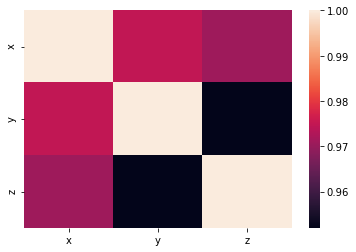

In [17]:
sns.heatmap(df[['x','y','z']].corr())

# 3. Sampling 

In [18]:
df.sample(n = 100)

,carat,cut,color,clarity,depth,table,price,x,y,z
48334,0.51,Ideal,D,VS1,62.1,55.0,1959,5.14,5.20,3.21
15930,1.00,Good,G,VS2,59.1,62.0,6369,6.42,6.45,3.80
36328,0.32,Premium,G,VVS2,62.0,55.0,936,4.42,4.39,2.73
37825,0.33,Premium,E,VS1,60.9,58.0,1002,4.49,4.45,2.72
53180,0.70,Very Good,G,VS1,62.3,58.0,2631,5.63,5.67,3.52
...,...,...,...,...,...,...,...,...,...,...
17502,1.02,Ideal,F,VS2,62.8,57.0,7037,6.41,6.36,4.01
8246,1.04,Ideal,G,SI2,61.4,57.0,4375,6.48,6.54,4.00
47590,0.61,Premium,D,SI1,62.3,58.0,1877,5.40,5.45,3.38
52076,0.71,Very Good,I,VVS1,63.5,57.0,2456,5.65,5.68,3.60


In [19]:
df.x.mean()

5.731157211716722

## 3.1 Sampling distribution of statistics

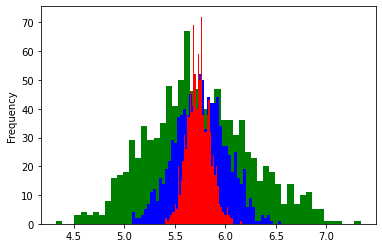

In [20]:
pd.Series([df.x.sample(n = 5).mean() for _ in range(1000)]).plot.hist(bins = 50, color = 'green')
pd.Series([df.x.sample(n = 20).mean() for _ in range(1000)]).plot.hist(bins = 50, color = 'blue')
pd.Series([df.x.sample(n = 100).mean() for _ in range(1000)]).plot.hist(bins = 50, color = 'red')

## 3.2 Standard error 

In [21]:
sp.sem(df.x)

0.0048299737209106675

In [22]:
np.std(df.x) / np.sqrt(len(df))

0.0048299289489778996

## 3.3 Confidence interval

In [23]:
[np.mean(df.x) - 1.96 * sp.sem(df.x), np.mean(df.x) + 1.96 * sp.sem(df.x)]

[5.721690463223737, 5.740623960209707]

In [24]:
import statsmodels.stats.api as sms
sms.DescrStatsW(df.x).tconfint_mean()

(5.721690424747487, 5.740623998685957)

# 4. Bootstrap

In [25]:
results = []
for _ in trange(1000):
    sample = resample(df.x)
    results.append(sample.median())
    
results = pd.Series(results)

print('Bootstrap Statistics:')
print(f'original: {df.x.median()}')
print(f'bias: {results.mean() - df.x.median()}')
print(f'std.error: {results.std()}')
print(f'95% confidence interval: {results.quantile(0.025)} ~ {results.quantile(1 - 0.025)}')


Bootstrap Statistics:
original: 5.7
bias: -0.003795000000000215
std.error: 0.005612885129724144
95% confidence interval: 5.69 ~ 5.71


# 5. Distributions and Probability

## 5.1 Uniform distribution

In [26]:
def uniform_pdf(x: float) -> float:
    return 1 if 0 <= x < 1 else 0

In [27]:
def uniform_cdf(x: float) -> float:
    '''Returns the probability that a uniform random variable is <= x'''
    if x < 0: 
        return 0
    elif x < 1:
        return x 
    else:
        return 1

## 5.1 Normal distribution

((array([-2.46203784, -2.12570747, -1.93122778, -1.79044653, -1.67819304,
         -1.58381122, -1.50174123, -1.42869743, -1.36256869, -1.30191411,
         -1.24570419, -1.19317644, -1.14374949, -1.09696931, -1.05247413,
         -1.00997067, -0.96921765, -0.93001393, -0.89218993, -0.85560121,
         -0.82012357, -0.78564937, -0.75208458, -0.71934648, -0.68736185,
         -0.65606548, -0.62539893, -0.59530962, -0.56574992, -0.53667655,
         -0.50804994, -0.47983378, -0.45199463, -0.42450149, -0.39732558,
         -0.37044003, -0.34381966, -0.31744076, -0.29128096, -0.26531902,
         -0.23953472, -0.21390872, -0.18842244, -0.16305799, -0.13779803,
         -0.1126257 , -0.08752455, -0.06247843, -0.03747145, -0.01248789,
          0.01248789,  0.03747145,  0.06247843,  0.08752455,  0.1126257 ,
          0.13779803,  0.16305799,  0.18842244,  0.21390872,  0.23953472,
          0.26531902,  0.29128096,  0.31744076,  0.34381966,  0.37044003,
          0.39732558,  0.42450149,  0.

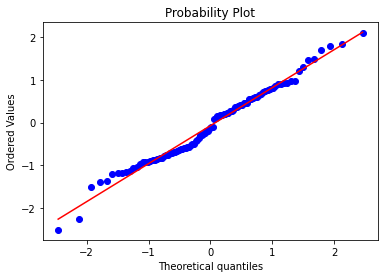

In [28]:
norm_sample = sp.norm.rvs(loc = 0, scale = 1, size = 100)
sp.probplot(norm_sample, plot = plt)

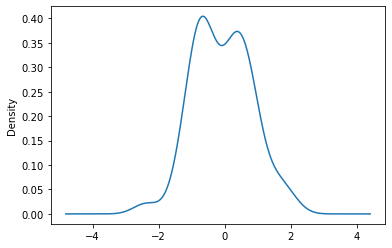

In [29]:
pd.Series(norm_sample).plot.density()

In [30]:
SQRT_TWO_PI = math.sqrt(2 * math.pi)

def normal_pdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (math.exp(-(x-mu) ** 2 / 2 / sigma ** 2) / (SQRT_TWO_PI * sigma))

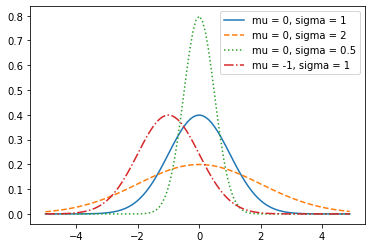

In [31]:
xs = [x / 10.0 for x in range(-50, 50)]

plt.plot(xs, [normal_pdf(x, sigma = 1) for x in xs], '-', label = 'mu = 0, sigma = 1')
plt.plot(xs, [normal_pdf(x, sigma = 2) for x in xs], '--', label = 'mu = 0, sigma = 2')
plt.plot(xs, [normal_pdf(x, sigma = 0.5) for x in xs], ':', label = 'mu = 0, sigma = 0.5')
plt.plot(xs, [normal_pdf(x, mu = -1) for x in xs], '-.', label = 'mu = -1, sigma = 1')
plt.legend()
plt.show()

In [32]:
def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x-mu) / math.sqrt(2) / sigma)) / 2

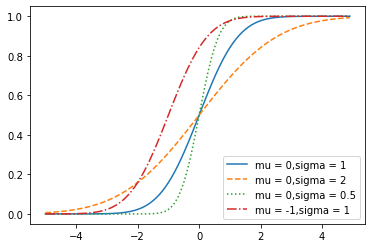

In [33]:
xs = [x / 10.0 for x in range(-50, 50)]

plt.plot(xs, [normal_cdf(x, sigma = 1) for x in xs], '-', label = 'mu = 0,sigma = 1')
plt.plot(xs, [normal_cdf(x, sigma = 2) for x in xs], '--', label = 'mu = 0,sigma = 2')
plt.plot(xs, [normal_cdf(x, sigma = 0.5) for x in xs], ':', label = 'mu = 0,sigma = 0.5')
plt.plot(xs, [normal_cdf(x, mu = -1) for x in xs], '-.', label = 'mu = -1,sigma = 1')
plt.legend(loc = 4)
plt.show()

In [34]:
def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    '''Find approximate inverse using binary search'''
    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance = tolerance)
    low_z = -10.0 
    hi_z = 10.0
    
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2
        mid_p = normal_cdf(mid_z)
        if mid_p < p:
            low_z = mid_z
        else:
            hi_z = mid_z
    return mid_z

### Central limit theorem

In [35]:
def bernoulli_trial(p: float) -> int:
    '''Returns 1 with probability p and 0 with probability 1-p'''
    return 1 if random.random() < p else 0

def binomial(n: int, p: float) -> int:
    '''Returns the sum of n bernoulli trials'''
    return sum(bernoulli_trial(p) for _ in range(n))

def binomial_histogram(p: float, n: int, num_points: int) -> None:
    '''Picks points from a Binomial(n, p) and plots their histogram'''
    data = [binomial(n, p) for _ in range(num_points)]
    
    histogram = Counter(data)
    plt.bar([x - 0.4 for x in histogram.keys()],
            [v / num_points for v in histogram.values()],
            0.8,
            color = '0.75')
    mu = p * n
    sigma = math.sqrt(n * p * (1 - p))
    
    xs = range(min(data), max(data) + 1)
    ys = [normal_cdf(i + 0.5, mu, sigma) - normal_cdf(i - 0.5, mu, sigma) for i in xs]
    
    plt.plot(xs, ys)
    plt.title('Binomial distribution vs Normal approximation')
    plt.show()

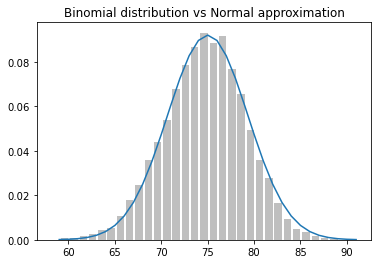

In [36]:
binomial_histogram(0.75, 100, 10000)

## 5.2 Long-tailed distribution

## 5.3 Student's t-distribution

((array([-2.46203784, -2.12570747, -1.93122778, -1.79044653, -1.67819304,
         -1.58381122, -1.50174123, -1.42869743, -1.36256869, -1.30191411,
         -1.24570419, -1.19317644, -1.14374949, -1.09696931, -1.05247413,
         -1.00997067, -0.96921765, -0.93001393, -0.89218993, -0.85560121,
         -0.82012357, -0.78564937, -0.75208458, -0.71934648, -0.68736185,
         -0.65606548, -0.62539893, -0.59530962, -0.56574992, -0.53667655,
         -0.50804994, -0.47983378, -0.45199463, -0.42450149, -0.39732558,
         -0.37044003, -0.34381966, -0.31744076, -0.29128096, -0.26531902,
         -0.23953472, -0.21390872, -0.18842244, -0.16305799, -0.13779803,
         -0.1126257 , -0.08752455, -0.06247843, -0.03747145, -0.01248789,
          0.01248789,  0.03747145,  0.06247843,  0.08752455,  0.1126257 ,
          0.13779803,  0.16305799,  0.18842244,  0.21390872,  0.23953472,
          0.26531902,  0.29128096,  0.31744076,  0.34381966,  0.37044003,
          0.39732558,  0.42450149,  0.

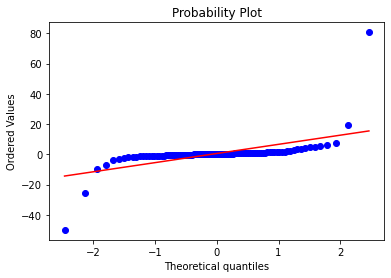

In [37]:
t_sample = sp.t.rvs(df = 1, size = 100)
sp.probplot(t_sample, plot = plt)

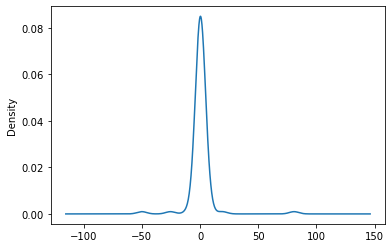

In [38]:
pd.Series(t_sample).plot.density()

## 5.4 Binomial distribution

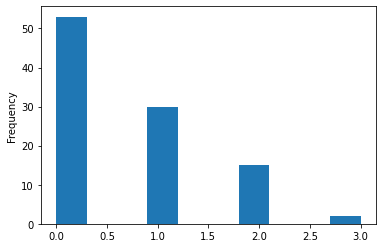

In [39]:
binomial_sample = sp.binom.rvs(n = 5, p = 0.1, size = 100)
pd.Series(binomial_sample).plot.hist()

In [40]:
sp.binom.pmf(k = 2, n = 5, p = 0.1)

0.0729

In [41]:
sp.binom.cdf(k = 2, n = 5, p = 0.1)

0.99144

## 5.5 Chi-square distribution

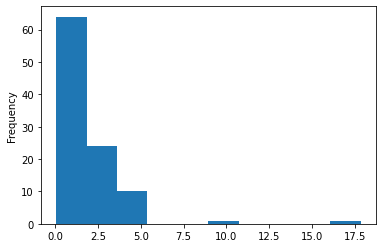

In [42]:
chi2_sample = sp.chi2.rvs(df = 2, size = 100)
pd.Series(chi2_sample).plot.hist()

## 5.6 F-distribution

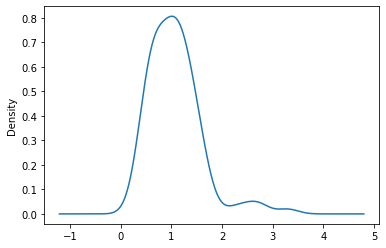

In [43]:
f_sample = sp.f.rvs(dfn = 20, dfd = 20, size = 100)
pd.Series(f_sample).plot.density()

## 5.7 Poisson distributions

### Poisson

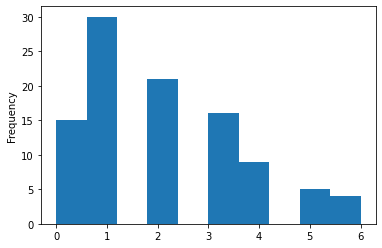

In [44]:
poisson_sample = sp.poisson.rvs(mu = 2, size = 100)
pd.Series(poisson_sample).plot.hist()

### Exponential

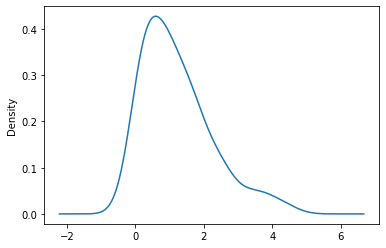

In [45]:
expon_sample = sp.expon.rvs(size = 100)
pd.Series(expon_sample).plot.density()

### Weibull

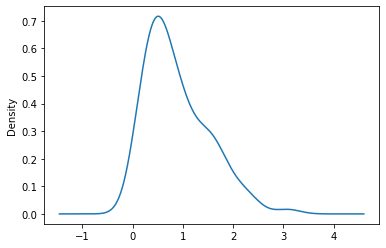

In [46]:
weibull_sample = sp.weibull_min.rvs(c = 1.5, size = 100)
pd.Series(weibull_sample).plot.density()

# 6. Statistical Hypothesis Testing

https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f

## 6.1 Hypothesis tests example

### Example: Flipping a coin

In [47]:
def normal_approximation_to_binomial(n: int, p: float) -> Tuple[float, float]:
    '''Returns mu and sigma corresponding to a Binomial(n, p)'''
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

normal_probability_below = normal_cdf

def normal_probability_above(lo: float, mu: float = 0, sigma: float = 1) -> float:
    '''The probability that an N(mu, sigma) is greater than lo'''
    return 1 - normal_cdf(lo, mu, sigma)

def normal_probability_between(lo: float, hi: float, mu: float = 0, sigma: float = 1) -> float:
    '''The probability that an N(mu, sigma) is between lo and hi'''
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

def normal_probability_outside(lo: float, hi: float, mu: float = 0, sigma: float = 1) -> float:
    return 1 - normal_probability_between(lo, hi, mu, sigma)

In [48]:
def normal_upper_bound(probability: float, mu: float = 0, sigma: float = 1) -> float:
    '''Returns the z for which P(Z <= z) = probability'''
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability: float, mu: float = 0, sigma: float = 1) -> float:
    '''Returns the z for which P(Z >= z) = probability'''
    return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability: float, mu: float = 0, sigma: float = 1) -> Tuple[float, float]:
    '''Returns the symmetric (about the mean) bounds that contain the specified probability'''
    tail_probability = (1 - probability) / 2
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    return lower_bound, upper_bound 

### Power

In [49]:
mu_0, sigma_0 = normal_approximation_to_binomial(n = 1000, p = 0.5)
mu_0, sigma_0

(500.0, 15.811388300841896)

In [50]:
lower_bound, upper_bound = normal_two_sided_bounds(probability = 0.95, mu = mu_0, sigma = sigma_0)
lower_bound, upper_bound

(469.01026640487555, 530.9897335951244)

In [51]:
mu_1, sigma_1 = normal_approximation_to_binomial(n = 1000, p = 0.55)
mu_1, sigma_1

(550.0, 15.732132722552274)

In [52]:
# two-sided
type_2_probability = normal_probability_between(lower_bound, upper_bound, mu_1, sigma_1)
power = 1 - type_2_probability
power

0.8865480012953671

In [53]:
# one-sided
hi = normal_upper_bound(0.95, mu_0, sigma_0)
type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability
power

0.9363794803307173

### P-value

In [54]:
def two_sided_p_value(x: float, mu: float = 0, sigma: float = 1) -> float:
    '''How likely are we to see a value at least as extreme as x (in either direction) if our values are from an N(mu, sigma)'''
    if x > mu:
        # if x is greater than the mean, so the tail is everything greater than x
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        # if x is less than the mean, so the tail is everything less than x
        return 2 * normal_probability_below(x, mu, sigma)

In [55]:
two_sided_p_value(529.5, mu_0, sigma_0)

0.06207721579598835

In [56]:
two_sided_p_value(531.5, mu_0, sigma_0)

0.046345287837786575

In [57]:
upper_p_value = normal_probability_above
lower_p_value = normal_probability_below 

In [58]:
upper_p_value(524.5, mu_0, sigma_0)

0.06062885772582072

In [59]:
upper_p_value(526.5, mu_0, sigma_0)

0.04686839508859242

### Confidence interval

In [60]:
p_hat = 525 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)
normal_two_sided_bounds(0.95, mu, sigma)

(0.4940490278129096, 0.5559509721870904)

In [61]:
p_hat = 540 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)
normal_two_sided_bounds(0.95, mu, sigma)

(0.5091095927295919, 0.5708904072704082)

### Example: Running an A/B test

In [62]:
def estimated_parameters(N: int, n: int) -> Tuple[float, float]:
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

In [63]:
def a_b_test_statistic(N_A: int, n_A: int, N_B: int, n_B: int) -> float:
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

In [64]:
z = a_b_test_statistic(1000, 200, 1000, 180)
two_sided_p_value(z)

0.254141976542236

In [65]:
z = a_b_test_statistic(1000, 200, 1000, 150)
two_sided_p_value(z)

0.003189699706216853

## 6.2 Resampling

### Permutation

In [66]:
df = pd.DataFrame(
    {'Page':['Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page A', 'Page A', 'Page A', 'Page A', 'Page A'],
    'Time':[0.21, 2.53, 0.35, 0.71, 0.67, 0.85, 2.11, 2.46, 1.32, 1.49, 0.68,
            0.75, 3.21, 3.33, 1.47, 1.87, 0.95, 1.26, 0.45, 0.48, 1.18, 1.47,
            3.42, 3.57, 1.97, 2.23, 0.39, 0.43, 0.65, 0.87, 1.73, 0.74, 0.86,
            1.18, 2.06, 0.93]})
df

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67
5,Page B,0.85
6,Page A,2.11
7,Page B,2.46
8,Page A,1.32
9,Page B,1.49


In [67]:
df.Page.value_counts()

Page A    21
Page B    15
Name: Page, dtype: int64

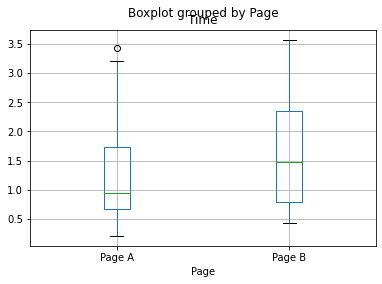

In [68]:
df.boxplot(by = 'Page', column = 'Time')

In [69]:
mean_a = df[df.Page == 'Page A'].Time.mean()
mean_b = df[df.Page == 'Page B'].Time.mean()
mean_a, mean_b

(1.2633333333333332, 1.62)

In [70]:
# Standard error
se = np.std(df.Time) * np.sqrt(1 / df.Page.value_counts()[0] + 1 / df.Page.value_counts()[1])
se

0.31413556819122196

In [71]:
# Confidence interval 
[mean_b - mean_a - 1.96 * se, mean_b - mean_a + 1.96 * se]

[-0.2590390469881281, 0.9723723803214619]

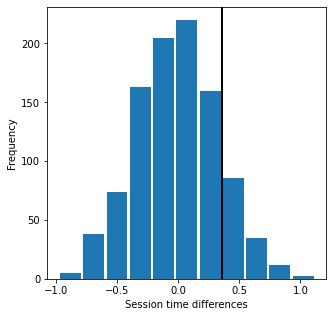

In [72]:
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(population = range(n), k = nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

nA = df[df.Page == 'Page A'].shape[0]
nB = df[df.Page == 'Page B'].shape[0]

perm_diffs = [perm_fun(df.Time, nA, nB) for _ in trange(1000)]

fig, ax = plt.subplots(figsize = (5,5))
ax.hist(perm_diffs, bins = 11, rwidth = 0.9)
ax.axvline(x = mean_b - mean_a, color = 'black', lw = 2)
ax.set_xlabel('Session time differences')
ax.set_ylabel('Frequency')
plt.show()

In [73]:
print(f'p-value: {np.mean(perm_diffs > mean_b - mean_a)}')

p-value: 0.135


## 6.3 Statistical significance and p-values

Outcome | Price A | Price B

Conversion | 200 | 182

No conversion | 23,539 | 22,406

In [74]:
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
obs_pct_diff

0.03675791182059275

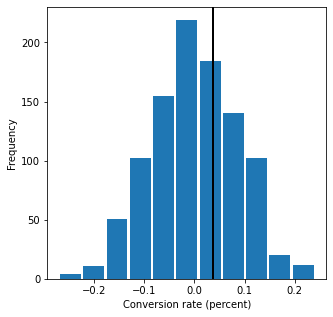

In [75]:
conversion = [0] * 45945
conversion.extend([1] * 382)
df = pd.Series(conversion)

perm_diffs = [100 * perm_fun(df, 23739, 22588) for _ in trange(1000)]

fig, ax = plt.subplots(figsize = (5,5))
ax.hist(perm_diffs, bins = 11, rwidth = 0.9)
ax.axvline(x = obs_pct_diff, color = 'black', lw = 2)
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')
plt.show()

In [76]:
print(f'p-value: {np.mean(np.array(perm_diffs) > obs_pct_diff)}')

p-value: 0.352


In [77]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = sp.chi2_contingency(survivors)
print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


## 6.4 t-tests

In [78]:
df = pd.DataFrame(
    {'Page':['Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page A', 'Page A', 'Page A', 'Page A', 'Page A'],
    'Time':[0.21, 2.53, 0.35, 0.71, 0.67, 0.85, 2.11, 2.46, 1.32, 1.49, 0.68,
            0.75, 3.21, 3.33, 1.47, 1.87, 0.95, 1.26, 0.45, 0.48, 1.18, 1.47,
            3.42, 3.57, 1.97, 2.23, 0.39, 0.43, 0.65, 0.87, 1.73, 0.74, 0.86,
            1.18, 2.06, 0.93]})
df

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67
5,Page B,0.85
6,Page A,2.11
7,Page B,2.46
8,Page A,1.32
9,Page B,1.49


In [79]:
res = sp.ttest_ind(df[df.Page == 'Page A'].Time,
                   df[df.Page == 'Page B'].Time,
                   equal_var = False)
print(f'formula p-value for single sided test: {res.pvalue / 2:.4f}')

formula p-value for single sided test: 0.1408


## 6.5 Multiple testing

## 6.6 Degrees of freedom

## 6.7 ANOVA

In [80]:
df = pd.DataFrame({'Page':['Page 1','Page 2','Page 3','Page 4'] * 5,
                   'Time':[164,178,175,155,172,191,193,166,177,182,171,164,156,185,163,170,195,177,176,168]})
df

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172
5,Page 2,191
6,Page 3,193
7,Page 4,166
8,Page 1,177
9,Page 2,182


In [81]:
observed_variance = df.groupby('Page').mean().var()[0]
print(f"Observed means: {df.groupby('Page').mean().values.ravel()}")
print(f'Variance: {observed_variance:.2f}')

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.43


In [82]:
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]

perm_variance = [perm_test(df) for _ in trange(3000)]
print(f'Pr(Prob): {np.mean(np.array(perm_variance) > observed_variance):.2f}')


Pr(Prob): 0.07


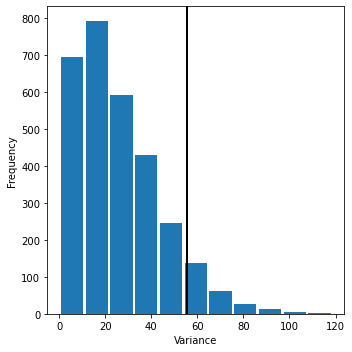

In [83]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

### F-statistics

In [84]:
model = smf.ols('Time ~ Page', data = df).fit()
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


### Two-way ANOVA

## 6.8 Chi-square test

In [85]:
df = pd.DataFrame({'Headline':['A','A','B','B','C','C'],
                   'Click':['Click','No-click','Click','No-click','Click','No-click'],
                   'Rate':[14,986,8,992,12,988]})
df

,Headline,Click,Rate
0,A,Click,14
1,A,No-click,986
2,B,Click,8
3,B,No-click,992
4,C,Click,12
5,C,No-click,988


In [86]:
df_pivot = df.pivot(index = 'Click', columns = 'Headline', values = 'Rate')
df_pivot

Headline,A,B,C
Click,,,
Click,14,8,12
No-click,986,992,988


In [87]:
box = [1] * (14+8+12)
box.extend([0] * (986+992+988))
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect for observe in row])
    return np.sum(pearson_residuals)

expected_clicks = (14+8+12) / 3
expected_noclicks = 1000 - expected_clicks
expected = [expected_clicks, expected_noclicks]
chi2observed = chi2(df_pivot.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in trange(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)

print(f'Observed chi2: {chi2observed:.2f}')
print(f'Resampled p-value: {resampled_p_value:.2f}')


Observed chi2: 1.67
Resampled p-value: 0.51


In [88]:
chisq, p_value, df, expected = sp.chi2_contingency(df_pivot)
print(f'Observed chi2: {chi2observed:.2f}')
print(f'p-value: {p_value:.2f}')

Observed chi2: 1.67
p-value: 0.43


## 6.9 Multi-arm bandit algorithm

## 6.10 Power and sample size

In [89]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
result = sm.stats.TTestIndPower().solve_power(effect_size = effect_size,
                                              alpha = 0.05,
                                              power = 0.8,
                                              alternative = 'larger')
print(f'Sample Size: {result:.2f}')

Sample Size: 116602.39


## 6.11 ExpAn - for experiment analysis

### Generate data

In [90]:
from expan.core.util import generate_random_data

ExpAn core init: v1.4.0


In [91]:
data, metadata = generate_random_data()

In [92]:
data

,entity,variant,normal_same,normal_shifted,feature,normal_shifted_by_feature,treatment_start_time,normal_unequal_variance,date
0,0,A,-1.487862,-0.616148,feature that only has one data point,-1.088533,7,0.003991,2015-01-01
1,1,B,-1.125186,1.783682,has,1.167307,3,-3.565511,2015-01-01
2,2,B,0.388819,1.007539,non,-1.055948,1,6.704536,2015-01-01
3,3,A,-1.173873,-0.889252,non,-0.152459,4,1.209668,2015-01-01
4,4,A,1.112634,0.434377,has,0.175988,4,0.148207,2015-01-01
...,...,...,...,...,...,...,...,...,...
9995,9995,B,-0.028124,0.706185,non,1.270654,5,-17.878939,2016-02-21
9996,9996,B,0.792395,1.829488,non,-1.001675,4,6.321226,2016-02-21
9997,9997,B,0.994518,-1.917363,non,-0.280280,4,-0.474425,2016-02-21
9998,9998,A,-0.697330,0.359386,has,0.800866,7,-0.678204,2016-02-21


In [93]:
metadata

{'primary_KPI': 'normal_shifted',
 'source': 'simulated',
 'experiment': 'random_data_generation'}

### Create experiment

In [94]:
from expan.core.experiment import Experiment

In [95]:
exp = Experiment(metadata = metadata)

### Create statistical test

In [96]:
from expan.core.statistical_test import KPI, Variants, StatisticalTest

In [97]:
kpi = KPI('normal_same')
variants = Variants(variant_column_name = 'variant', control_name = 'B', treatment_name = 'A')
test = StatisticalTest(data = data, kpi = kpi, features = [], variants = variants)

### Analysis

In [98]:
result = exp.analyze_statistical_test(test)
result

INFO:expan.core.experiment:One analysis with kpi '{
    "name": "normal_same"
}', control variant 'B', treatment variant 'A' and features [[]] has just started
INFO:expan.core.experiment:Control group size: 3892
INFO:expan.core.experiment:Treatment group size: 6108
INFO:expan.core.statistics:The distribution of two samples is assumed normal. Performing the sample difference distribution calculation.
INFO:expan.core.statistics:Delta calculation finished!


{
    "result": {
        "confidence_interval": [
            {
                "percentile": 2.5,
                "value": -0.007138761863314601
            },
            {
                "percentile": 97.5,
                "value": 0.0732438406769919
            }
        ],
        "control_statistics": {
            "mean": -0.007833095215783122,
            "sample_size": 3892,
            "variance": 0.991195545472199
        },
        "delta": 0.03305253940683865,
        "p": 0.10698672122297047,
        "statistical_power": 0.36400577293301273,
        "treatment_statistics": {
            "mean": 0.025219444191055533,
            "sample_size": 6108,
            "variance": 1.0046096975922052
        }
    },
    "test": {
        "features": [],
        "kpi": {
            "name": "normal_same"
        },
        "variants": {
            "control_name": "B",
            "treatment_name": "A",
            "variant_column_name": "variant"
        }
    }
}

In [99]:
pd.read_json(result.toJson())

,result,test
confidence_interval,"[{'percentile': 2.5, 'value': -0.0071387618633...",NaN
control_statistics,"{'mean': -0.007833095215783, 'sample_size': 38...",NaN
delta,0.0330525,NaN
p,0.106987,NaN
statistical_power,0.364006,NaN
treatment_statistics,"{'mean': 0.025219444191055002, 'sample_size': ...",NaN
features,NaN,[]
kpi,NaN,{'name': 'normal_same'}
variants,NaN,"{'control_name': 'B', 'treatment_name': 'A', '..."


### Permutation check

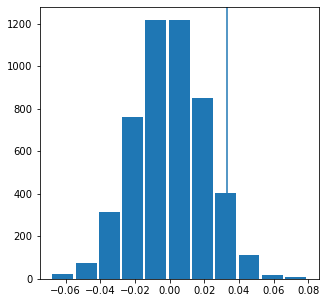

one-side p-value: 0.0566


In [100]:
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(population = range(n), k = nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_A].mean() - x.loc[idx_B].mean()

mean_B = data[data.variant == 'B'].normal_same.mean()
mean_A = data[data.variant == 'A'].normal_same.mean()

nA = data[data.variant == 'A'].shape[0]
nB = data[data.variant == 'B'].shape[0]

perm_diffs = [perm_fun(data.normal_same, nA, nB) for _ in trange(5000)]

fig, ax = plt.subplots(figsize = (5,5))
ax.hist(perm_diffs, bins = 11, rwidth = 0.9)
ax.axvline(x = mean_A - mean_B)
plt.show()
print(f'one-side p-value: {np.mean(perm_diffs > mean_A - mean_B)}')

### Subgroup analysis

In [101]:
from expan.core.statistical_test import FeatureFilter 

In [102]:
feature = FeatureFilter('feature', 'has')
test = StatisticalTest(data = data, kpi = kpi, features = [feature], variants = variants)

In [103]:
exp.analyze_statistical_test(test)

INFO:expan.core.experiment:One analysis with kpi '{
    "name": "normal_same"
}', control variant 'B', treatment variant 'A' and features [[('feature', 'has')]] has just started
INFO:expan.core.experiment:Control group size: 1966
INFO:expan.core.experiment:Treatment group size: 3067
INFO:expan.core.statistics:The distribution of two samples is assumed normal. Performing the sample difference distribution calculation.
INFO:expan.core.statistics:Delta calculation finished!


{
    "result": {
        "confidence_interval": [
            {
                "percentile": 2.5,
                "value": 0.006671086424345475
            },
            {
                "percentile": 97.5,
                "value": 0.11917967082265521
            }
        ],
        "control_statistics": {
            "mean": -0.03325546053022948,
            "sample_size": 1966,
            "variance": 0.9502823933483748
        },
        "delta": 0.06292537862350035,
        "p": 0.028358778147368372,
        "statistical_power": 0.5922702558935107,
        "treatment_statistics": {
            "mean": 0.02966991809327087,
            "sample_size": 3067,
            "variance": 1.0096351883915924
        }
    },
    "test": {
        "features": [
            {
                "column_name": "feature",
                "column_value": "has"
            }
        ],
        "kpi": {
            "name": "normal_same"
        },
        "variants": {
            "control_name": "

### Statistical test suite

In [104]:
from expan.core.statistical_test import *

In [105]:
kpi = KPI('normal_same')
variants = Variants(variant_column_name = 'variant', control_name = 'B', treatment_name = 'A')

feature_1 = FeatureFilter('feature', 'has')
feature_2 = FeatureFilter('feature', 'non')
feature_3 = FeatureFilter('feature', 'feature that only has one data point')

test_subgroup1 = StatisticalTest(data, kpi, [feature_1], variants)
test_subgroup2 = StatisticalTest(data, kpi, [feature_2], variants)
test_subgroup3 = StatisticalTest(data, kpi, [feature_3], variants)

tests = [test_subgroup1, test_subgroup2, test_subgroup3]
test_suite = StatisticalTestSuite(tests = tests, correction_method = CorrectionMethod.BH)

exp.analyze_statistical_test_suite(test_suite)

INFO:expan.core.experiment:Statistical test suite analysis with 3 tests, testmethod fixed_horizon, correction method CorrectionMethod.BH has just started
INFO:expan.core.experiment:One analysis with kpi '{
    "name": "normal_same"
}', control variant 'B', treatment variant 'A' and features [[('feature', 'has')]] has just started
INFO:expan.core.experiment:Control group size: 1966
INFO:expan.core.experiment:Treatment group size: 3067
INFO:expan.core.statistics:The distribution of two samples is assumed normal. Performing the sample difference distribution calculation.
INFO:expan.core.statistics:Delta calculation finished!
INFO:expan.core.experiment:One analysis with kpi '{
    "name": "normal_same"
}', control variant 'B', treatment variant 'A' and features [[('feature', 'non')]] has just started
INFO:expan.core.experiment:Control group size: 1926
INFO:expan.core.experiment:Treatment group size: 3040
INFO:expan.core.statistics:The distribution of two samples is assumed normal. Performi

{
    "correction_method": "BH",
    "results": [
        {
            "result": {
                "corrected_test_statistics": {
                    "confidence_interval": [
                        {
                            "percentile": 1.25,
                            "value": -0.0014104640151739734
                        },
                        {
                            "percentile": 98.75,
                            "value": 0.1272612212621747
                        }
                    ],
                    "control_statistics": {
                        "mean": -0.03325546053022948,
                        "sample_size": 1966,
                        "variance": 0.9502823933483748
                    },
                    "delta": 0.06292537862350035,
                    "p": 0.028358778147368372,
                    "statistical_power": 0.4808382307266412,
                    "treatment_statistics": {
                        "mean": 0.02966991809327087,
     

### Statistics

In [106]:
import expan.core.statistics

In [107]:
expan.core.statistics.estimate_sample_size(x = data.normal_same, mde = 0.1, r = 0.5, alpha = 0.05, beta = 0.2)

23126555.02628001